<a href="https://colab.research.google.com/github/sdelta/ImageGen/blob/main/filter_ffhq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install click requests tqdm pyspng ninja imageio-ffmpeg==0.4.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 205 kB 7.6 MB/s 
     |████████████████████████████████| 145 kB 63.7 MB/s 
     |████████████████████████████████| 26.9 MB 1.4 MB/s 


In [3]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Total 128 (delta 0), reused 0 (delta 0), pack-reused 128
Receiving objects: 100% (128/128), 1.12 MiB | 19.79 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [4]:
!python stylegan2-ada-pytorch/dataset_tool.py --help

Usage: dataset_tool.py [OPTIONS]

  Convert an image dataset into a dataset
  archive usable with StyleGAN2 ADA PyTorch.

  The input dataset format is guessed from the
  --source argument:

  --source *_lmdb/                    Load LSUN dataset
  --source cifar-10-python.tar.gz     Load CIFAR-10 dataset
  --source train-images-idx3-ubyte.gz Load MNIST dataset
  --source path/                      Recursively load all images from path/
  --source dataset.zip                Recursively load all images from dataset.zip

  Specifying the output format and path:

  --dest /path/to/dir                 Save output files under /path/to/dir
  --dest /path/to/dataset.zip         Save output files into /path/to/dataset.zip

  The output dataset format can be either an
  image folder or an uncompressed zip archive.
  Zip archives makes it easier to move datasets
  around file servers and clusters, and may
  offer better training performance on network
  file systems.

  Images within the dataset

In [6]:
!mkdir dataset

In [7]:
!cp drive/MyDrive/datasets/ffhq_256/ffhq.zip ./dataset

In [ ]:
!cd dataset && unzip ffhq.zip

In [14]:
!python stylegan2-ada-pytorch/dataset_tool.py --source=resized   --dest=ffhq.zip

100% 70000/70000 [09:41<00:00, 120.47it/s]


In [16]:
!cp -vf ffhq.zip drive/MyDrive/datasets/ffhq_256/

'ffhq.zip' -> 'drive/MyDrive/datasets/ffhq_256/ffhq.zip'


In [9]:
!ls dataset

00000  00008  00016  00024  00032  00040  00048  00056	00064
00001  00009  00017  00025  00033  00041  00049  00057	00065
00002  00010  00018  00026  00034  00042  00050  00058	00066
00003  00011  00019  00027  00035  00043  00051  00059	00067
00004  00012  00020  00028  00036  00044  00052  00060	00068
00005  00013  00021  00029  00037  00045  00053  00061	00069
00006  00014  00022  00030  00038  00046  00054  00062	dataset.json
00007  00015  00023  00031  00039  00047  00055  00063	ffhq.zip


In [27]:
!pip install open_clip_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 6.0 MB/s 
     |████████████████████████████████| 182 kB 72.6 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 


In [13]:
!ls dataset/00000 -1 | head

img00000000.png
img00000001.png
img00000002.png
img00000003.png
img00000004.png
img00000005.png
img00000006.png
img00000007.png
img00000008.png
img00000009.png


In [32]:
import torch
import open_clip
from PIL import Image
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
assert device == "cuda"

model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

model = model.to(device)

cuda


In [111]:
load_img = lambda p: Image.open(f"dataset/00000/img00000{p:03d}.png")

src_images = [load_img(ind) for ind in range(3, 7)]
src_texts = ["a man", "a women", "a baby", "glasses", "without glasses", "mustache", "without mustache"]
images = torch.tensor(np.stack([preprocess(img) for img in src_images])).to(device)
texts = tokenizer(src_texts).to(device)

In [112]:
images.shape

torch.Size([4, 3, 224, 224])

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [117]:
def get_similarities(texts, images):
    with torch.no_grad():
        image_features = model.encode_image(images).float()
        text_features = model.encode_text(texts).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity

In [113]:
with torch.no_grad():
    image_features = model.encode_image(images).float()
    text_features = model.encode_text(texts).float()

In [114]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [119]:
assert (similarity == get_similarities(texts, images)).all()

In [120]:
similarity.shape

(7, 4)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

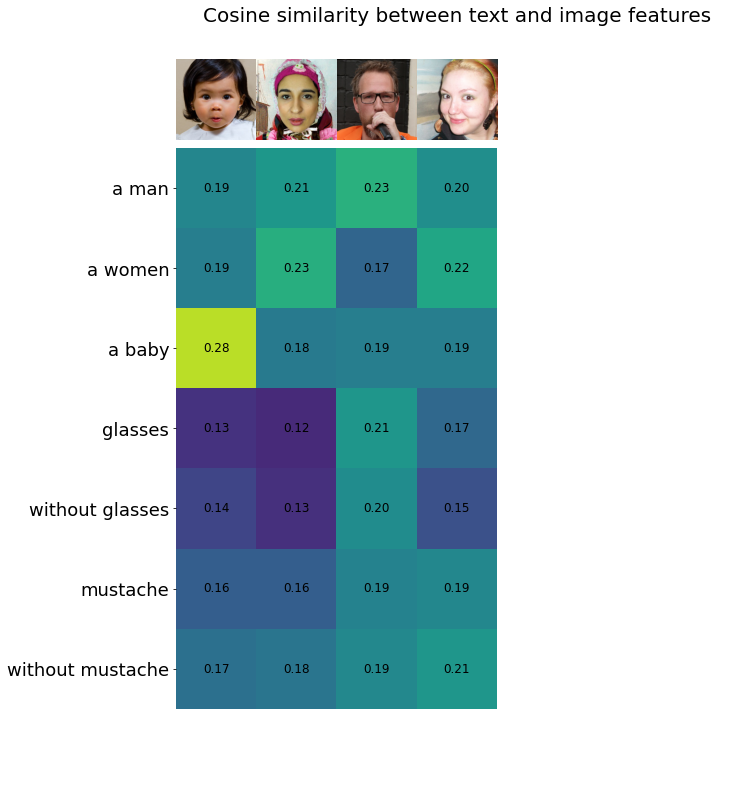

In [115]:
import matplotlib.pyplot as plt

count = len(src_texts)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), src_texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(src_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

In [150]:
from torchvision.datasets import ImageFolder

class ImageFolderWithPaths(ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path



dataset = ImageFolderWithPaths("dataset", transform=preprocess)

In [151]:
len(dataset)

70000

In [163]:
from torch.utils.data import DataLoader

dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=2)

In [153]:
!mkdir output_dir

mkdir: cannot create directory ‘output_dir’: File exists


In [ ]:
from torchvision.utils import save_image
from tqdm import tqdm
import shutil


src_texts = ["glasses"]
texts = tokenizer(src_texts).to(device)

img_number = 0

for batch, _, pathes in tqdm(dataloader):
    similarities = get_similarities(texts, batch.to(device))
    for ind in range(batch.shape[0]):
        if similarities[0][ind] > 0.2:
            output_path = f'output_dir/img_{img_number:05d}.png'
            #save_image(batch[ind], output_path)
            shutil.copy(pathes[ind], output_path)
            img_number += 1

In [165]:
!ls -1 output_dir | wc -l 

197


In [ ]:
Image.open("output_dir/img_00050.png")

In [160]:
!python stylegan2-ada-pytorch/dataset_tool.py --source=output_dir   --dest=ffhq_glasses.zip

100% 6812/6812 [00:46<00:00, 145.79it/s]


In [161]:
!cp ffhq_glasses.zip drive/MyDrive/datasets/ffhq_256